In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Model Building (Architecture)

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dropout, BatchNormalization,
    Dense, Concatenate
)
from tensorflow.keras.optimizers import Adam

# 1️⃣ Mixed precision
mixed_precision.set_global_policy('mixed_float16')

# 2️⃣ Triplet loss & accuracy
def triplet_loss(alpha=0.3):
    def loss(_, y_pred):
        a, p, n = tf.split(y_pred, num_or_size_splits=3, axis=1)  # each is [B,128]
        pos = tf.reduce_sum(tf.square(a - p), axis=1)
        neg = tf.reduce_sum(tf.square(a - n), axis=1)
        return tf.reduce_mean(tf.maximum(pos - neg + alpha, 0.0))
    return loss

def triplet_accuracy(alpha=0.3):
    def acc(_, y_pred):
        a, p, n = tf.split(y_pred, num_or_size_splits=3, axis=1)
        pos = tf.reduce_sum(tf.square(a - p), axis=1)
        neg = tf.reduce_sum(tf.square(a - n), axis=1)
        return tf.reduce_mean(tf.cast(pos + alpha < neg, tf.float32))
    return acc

# 3️⃣ Build 128-d embedding extractor
def build_embedding_model():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    return Model(base.input, x, name='EmbeddingModel')

# 4️⃣ Build full triplet network
def build_triplet_model(embedder):
    A = Input((224,224,3), name='Anchor')
    P = Input((224,224,3), name='Positive')
    N = Input((224,224,3), name='Negative')
    a_e = embedder(A)
    p_e = embedder(P)
    n_e = embedder(N)
    merged = Concatenate(axis=1)([a_e, p_e, n_e])  # shape [B, 128*3]
    model = Model([A,P,N], merged, name='TripletNet')
    model.compile(
        optimizer=Adam(1e-4),
        loss=triplet_loss(),
        metrics=[triplet_accuracy()]
    )
    return model

# 5️⃣ Image preprocessing
def preprocess_image(path):
    img = load_img(path, target_size=(224,224))
    arr = img_to_array(img)
    return preprocess_input(arr.astype('float32'))

# 6️⃣ Load & split
def load_data(root, split=0.8):
    cats = ['Normal','Sickle']
    all_paths = {
        c: [os.path.join(root,c,f) for f in os.listdir(os.path.join(root,c))
            if f.lower().endswith(('png','jpg','jpeg'))]
        for c in cats
    }
    train, test = {}, {}
    for c, imgs in all_paths.items():
        random.shuffle(imgs)
        cut = int(len(imgs)*split)
        train[c], test[c] = imgs[:cut], imgs[cut:]
    return train, test

# 7️⃣ Semi-hard triplet mining
def generate_triplets(embedder, paths, per_class=300, margin=0.3):
    cats = list(paths.keys())
    # precompute embeddings
    embs = {}
    for c in cats:
        imgs = paths[c]
        arr  = np.stack([preprocess_image(p) for p in imgs], axis=0)
        embs[c] = (imgs, embedder.predict(arr, verbose=0))
    triplets = []
    for c in cats:
        imgs_c, e_c = embs[c]
        neg_imgs = sum((embs[o][0] for o in cats if o!=c), [])
        neg_embs = np.vstack([embs[o][1] for o in cats if o!=c])
        for i, img_path in enumerate(imgs_c):
            anchor = e_c[i]
            d_pos  = np.sum((e_c - anchor)**2, axis=1)
            pos_i  = np.argmax(d_pos)
            d_neg  = np.sum((neg_embs - anchor)**2, axis=1)
            hard   = np.where((d_neg>d_pos.min()) & (d_neg<d_pos.min()+margin))[0]
            neg_i  = np.random.choice(hard) if len(hard)>0 else np.argmin(d_neg)
            triplets.append((img_path, imgs_c[pos_i], neg_imgs[neg_i]))
        if len(triplets) >= per_class*len(cats):
            break
    random.shuffle(triplets)
    return triplets

# 8️⃣ Build a tf.data.Dataset from a Python generator
def triplet_dataset(triplets, batch_size):
    def gen():
        # infinite loop
        while True:
            batch = random.sample(triplets, batch_size)
            A = np.stack([preprocess_image(a) for a,_,_ in batch], axis=0)
            P = np.stack([preprocess_image(p) for _,p,_ in batch], axis=0)
            N = np.stack([preprocess_image(n) for _,_,n in batch], axis=0)
            # yield inputs as a list, and dummy labels
            yield ({"Anchor":A, "Positive":P, "Negative":N}, np.zeros((batch_size,1),dtype='float32'))

    # precisely declare the output signature:
    input_spec = {
      "Anchor":   tf.TensorSpec((batch_size,224,224,3), tf.float32),
      "Positive": tf.TensorSpec((batch_size,224,224,3), tf.float32),
      "Negative": tf.TensorSpec((batch_size,224,224,3), tf.float32),
    }
    label_spec = tf.TensorSpec((batch_size,1), tf.float32)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(input_spec, label_spec)
    )
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    DATA_DIR = '/content/drive/My Drive/DatasetV2'
    train_paths, _ = load_data(DATA_DIR)

    # build models
    emb_model     = build_embedding_model()
    triplet_model = build_triplet_model(emb_model)

    # mine triplets
    triplets = generate_triplets(emb_model, train_paths, per_class=300)

    # create tf.data.Dataset
    BATCH = 16
    ds    = triplet_dataset(triplets, batch_size=BATCH)
    steps = len(triplets) // BATCH

    # train
    triplet_model.fit(
        ds,
        epochs=30,
        steps_per_epoch=steps
    )

    # save the embedding extractor
    emb_model.save('resnet50_embedding_model.h5')


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - acc: 0.4586 - loss: 22.1134
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4883 - loss: 16.8157
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.6163 - loss: 11.8379
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.7624 - loss: 7.1553
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.8560 - loss: 5.2589
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.9103 - loss: 2.7878
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.8998 - loss: 2.0414
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.9079 - loss: 3.0176
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.9503 - loss: 1.4098
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - acc: 0.9443 - loss: 1.3901
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - acc: 0.9457 - loss: 1.6088
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - acc: 0.9637 - loss: 0.6566
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s

In [ ]:
    save_path = '/content/drive/My Drive/resnet50_embedding_model.h5'
    emb_model.save(save_path)
    print(f"Embedding model saved to {save_path}")

Embedding model saved to /content/drive/My Drive/resnet50_embedding_model.h5


Fetching Layer Names (for xai)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer

# 1️⃣ Define a no-op Cast layer so that load_model can handle mixed-precision artifacts
class Cast(Layer):
    def call(self, inputs):
        return inputs

# 2️⃣ Load your saved embedding model, registering Cast
model_path = '/content/drive/My Drive/resnet50_embedding_model.h5'
model = load_model(model_path, compile=False, custom_objects={'Cast': Cast})

# 3️⃣ Print layer index, name, and output shape (with fallbacks for InputLayer)
print("Idx | Layer name                     | Output shape")
print("--- | ------------------------------ | ------------")
for i, layer in enumerate(model.layers):
    # first try the usual .output_shape
    if hasattr(layer, 'output_shape'):
        shape = layer.output_shape
    # if not, maybe it's an InputLayer—try input_shape
    elif hasattr(layer, 'input_shape'):
        shape = layer.input_shape
    else:
        shape = "unknown"
    print(f"{i:3d} | {layer.name:30s} | {shape}")


Idx | Layer name                     | Output shape
--- | ------------------------------ | ------------
  0 | input_layer_1                  | unknown
  1 | cast_2                         | unknown
  2 | conv1_pad                      | unknown
  3 | conv1_conv                     | unknown
  4 | conv1_bn                       | unknown
  5 | conv1_relu                     | unknown
  6 | pool1_pad                      | unknown
  7 | pool1_pool                     | unknown
  8 | conv2_block1_1_conv            | unknown
  9 | conv2_block1_1_bn              | unknown
 10 | conv2_block1_1_relu            | unknown
 11 | conv2_block1_2_conv            | unknown
 12 | conv2_block1_2_bn              | unknown
 13 | conv2_block1_2_relu            | unknown
 14 | conv2_block1_0_conv            | unknown
 15 | conv2_block1_3_conv            | unknown
 16 | conv2_block1_0_bn              | unknown
 17 | conv2_block1_3_bn              | unknown
 18 | conv2_block1_add               | unknown
 19

Training the KNN Classifier on embeddings

Number of train images: 836
Number of test images: 200
7/7 [==============================] - 1s 212ms/step
Validation Accuracy: 0.8400
Confusion Matrix:
[[89 11]
 [21 79]]
Precision: 0.8778
Recall: 0.7900
F1 Score: 0.8316
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       100
           1       0.88      0.79      0.83       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



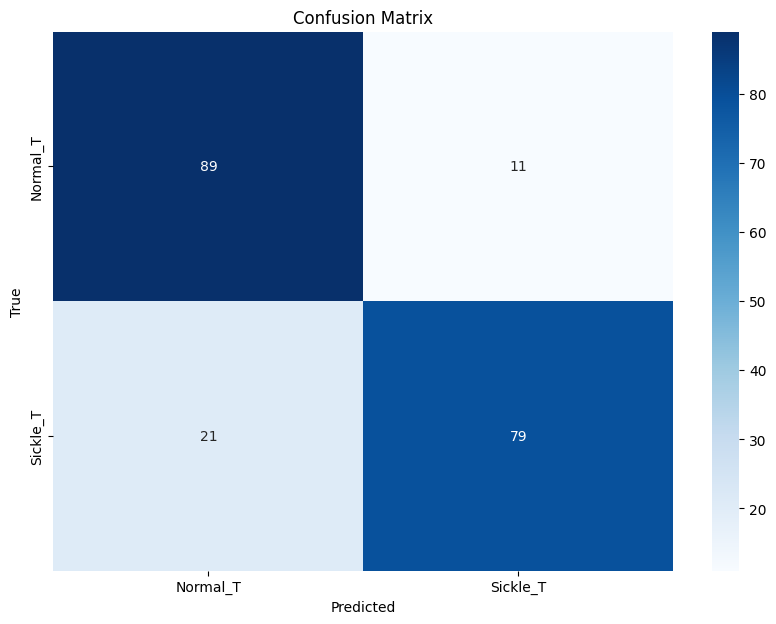

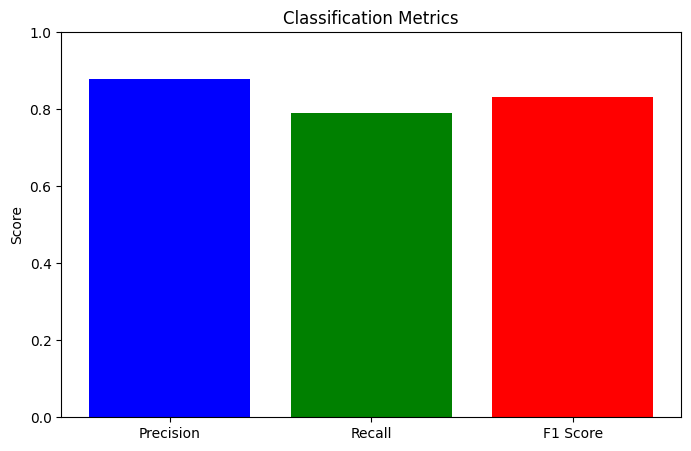

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path)
    if img.size != (224, 224):
        img = img.resize((224, 224))
    img = img_to_array(img)
    return preprocess_input(img)

# Function to calculate classification metrics and visualize them
def validate_and_visualize(embedding_model, train_paths, test_paths):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    for category, paths in train_paths.items():
        label = 0 if category == 'Normal_New' else 1
        for path in paths:
            img = preprocess_image(path)
            train_images.append(img)
            train_labels.append(label)

    for category, paths in test_paths.items():
        label = 0 if category == 'Normal_T' else 1
        for path in paths:
            img = preprocess_image(path)
            test_images.append(img)
            test_labels.append(label)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # Ensure the number of images is as expected
    print(f'Number of train images: {len(train_images)}')
    print(f'Number of test images: {len(test_images)}')

    train_embeddings = embedding_model.predict(train_images)
    test_embeddings = embedding_model.predict(test_images)

    # Using K-Nearest Neighbors for classification in embedding space
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_embeddings, train_labels)
    pred_labels = knn.predict(test_embeddings)

    # Calculate metrics
    accuracy = accuracy_score(test_labels, pred_labels)
    print(f'Validation Accuracy: {accuracy:.4f}')

    conf_matrix = confusion_matrix(test_labels, pred_labels)
    precision = precision_score(test_labels, pred_labels)
    recall = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)
    class_report = classification_report(test_labels, pred_labels)

    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Classification Report:\n{class_report}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal_T', 'Sickle_T'], yticklabels=['Normal_T', 'Sickle_T'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot precision, recall, and F1 score
    metrics = {'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.show()

# Example of how to load data paths (adjust to your dataset structure)
def load_data(directory, split_ratio=0.8):
    categories = ['Normal_New', 'Sickle_New']
    paths = {category: [os.path.join(directory, category, fname) for fname in os.listdir(os.path.join(directory, category)) if fname.endswith(('png', 'jpg', 'jpeg'))] for category in categories}
    train_paths = {}
    test_paths = {}
    for category, images in paths.items():
        np.random.shuffle(images)
        split = int(len(images) * split_ratio)
        train_paths[category] = images[:split]
        test_paths[category] = images[split:]
    return train_paths, test_paths

# Function to load test data
def load_test_data(directory):
    categories = ['Normal_T', 'Sickle_T']
    paths = {category: [os.path.join(directory, category, fname) for fname in os.listdir(os.path.join(directory, category)) if fname.endswith(('png', 'jpg', 'jpeg'))] for category in categories}
    return paths

# Directory to your original training dataset in Google Drive
train_directory = '/content/drive/My Drive/Dataset/Dataset/Train'

# Load original training data
train_paths, _ = load_data(train_directory)

# Directory to your new test dataset in Google Drive
test_directory = '/content/drive/My Drive/Test'

# Load new test data
test_paths = load_test_data(test_directory)

# Run validation and visualization
validate_and_visualize(embedding_model, train_paths, test_paths)

XAI implementation using weights of the final layer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing image: /content/drive/My Drive/Test/Normal_T/new_1042.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


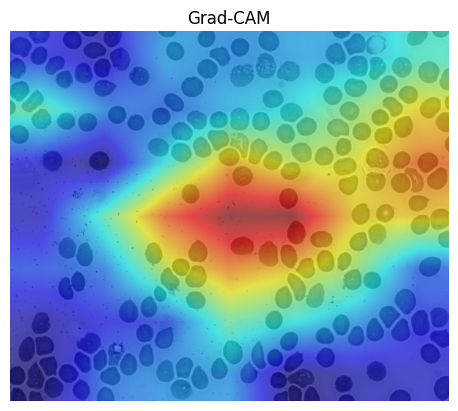

Processing image: /content/drive/My Drive/Test/Normal_T/new_1664.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


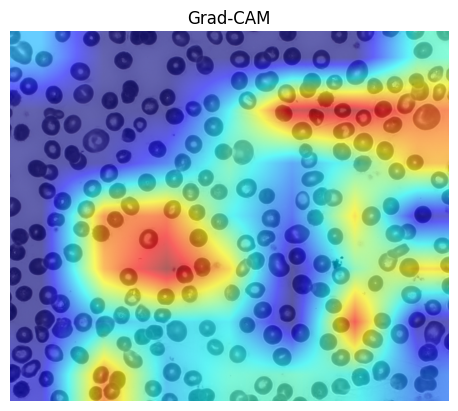

Processing image: /content/drive/My Drive/Test/Normal_T/new_1165.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


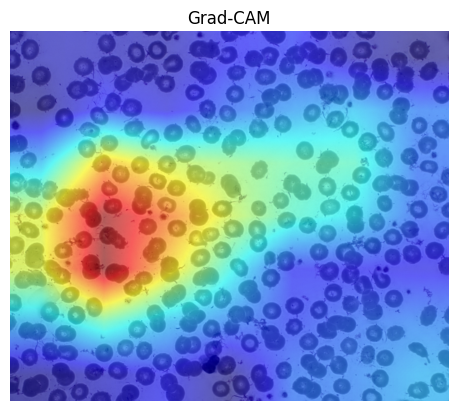

Processing image: /content/drive/My Drive/Test/Normal_T/new_1537.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


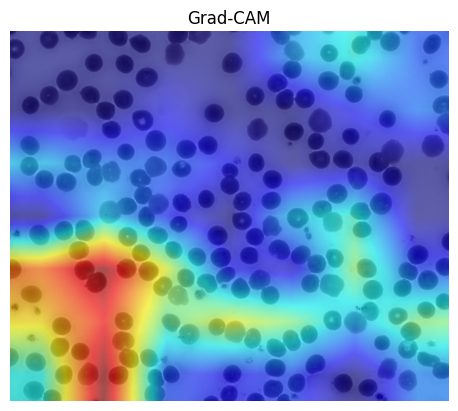

Processing image: /content/drive/My Drive/Test/Normal_T/new_1484.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


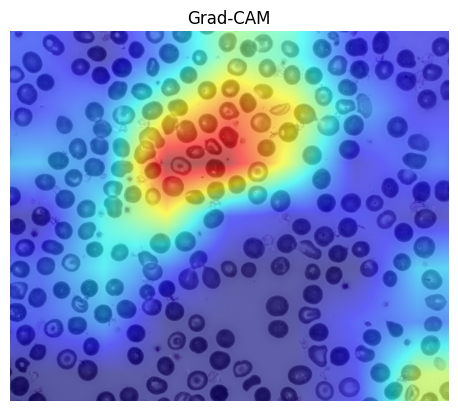

Processing image: /content/drive/My Drive/Test/Sickle_T/new_539.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


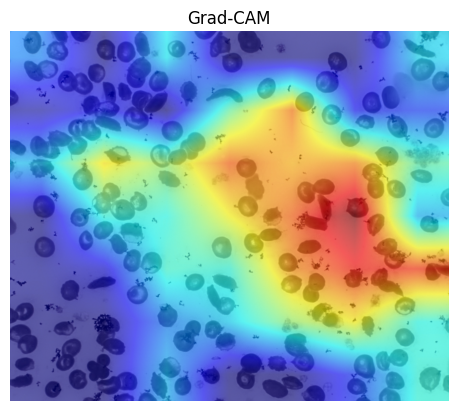

Processing image: /content/drive/My Drive/Test/Sickle_T/new_726.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


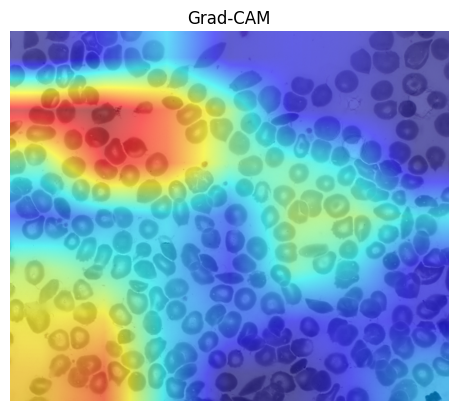

Processing image: /content/drive/My Drive/Test/Sickle_T/new_517.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


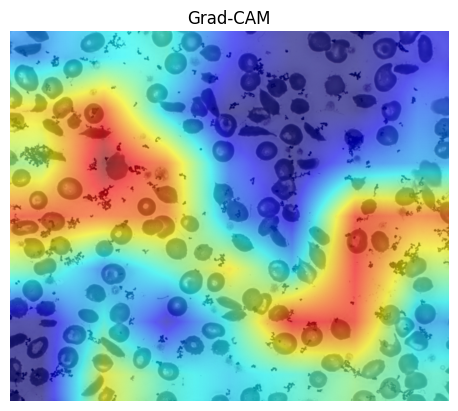

Processing image: /content/drive/My Drive/Test/Sickle_T/new_3.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


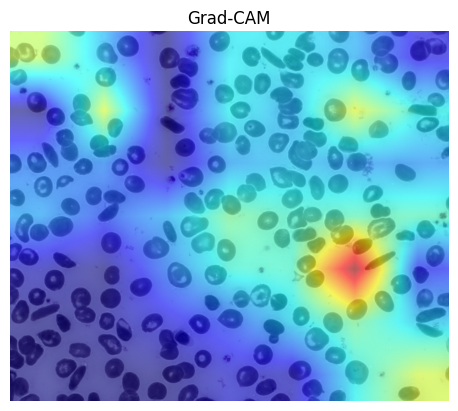

Processing image: /content/drive/My Drive/Test/Sickle_T/new_943.jpg
Heatmap shape: (7, 7)
Heatmap max value: 1.0, min value: 0.0
Loaded image shape: (2160, 2560, 3)


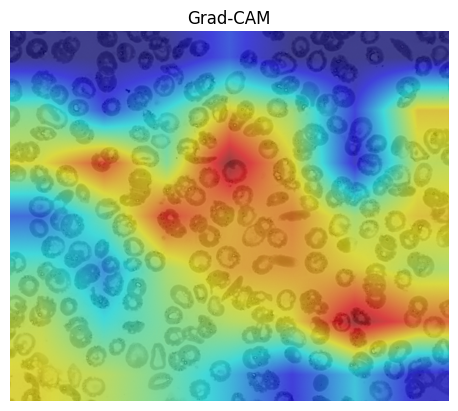

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import cv2
import os
import random

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the saved model
model_path = 'resnet50_triplet_model_opensource_imbalance.h5'
model = load_model(model_path, compile=False)

# Extract the embedding model from the trained model
embedding_model = model.get_layer('model_4')  # Extracting the model layer

# Create a new model using the input of model and the output of the same layer
embedding_model = Model(inputs=embedding_model.input, outputs=embedding_model.output)

# Function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name, cls=-1):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if cls == -1:
            cls = np.argmax(predictions[0])
        loss = predictions[:, cls]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Debugging: Print heatmap shape and values
    print(f"Heatmap shape: {heatmap.shape}")
    print(f"Heatmap max value: {np.max(heatmap)}, min value: {np.min(heatmap)}")

    return heatmap

# Function to overlay the heatmap on the image
def overlay_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    print(f"Loaded image shape: {img.shape}")  # Debugging: print image shape
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))  # Ensure heatmap is float32
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return overlayed_img

# Directory to your new test dataset in Google Drive
normal_test_dir = '/content/drive/My Drive/Test/Normal_T'
sickle_test_dir = '/content/drive/My Drive/Test/Sickle_T'

# List all images in the directories
normal_image_paths = [os.path.join(normal_test_dir, fname) for fname in os.listdir(normal_test_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
sickle_image_paths = [os.path.join(sickle_test_dir, fname) for fname in os.listdir(sickle_test_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]

# Combine the lists and select images
selected_images = random.sample(normal_image_paths, 5) + random.sample(sickle_image_paths, 5)

# Process each selected image
for image_path in selected_images:
    print(f"Processing image: {image_path}")
    preprocessed_img = preprocess_image(image_path)

    # Specify the layer to visualize
    layer_name = 'conv5_block3_out'  # Replace with the name of the target convolutional layer in your model

    # Generate Grad-CAM heatmap
    heatmap = generate_gradcam(embedding_model, preprocessed_img, layer_name)

    # Overlay the heatmap on the original image
    overlayed_img = overlay_gradcam(image_path, heatmap)

    # Display the image
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "EmbeddingModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 224, 224,  │          0 │ cast_7[0][0]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast_6[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,858,688 (91.01 MB)

 Trainable params: 23,801,216 (90.79 MB)

 Non-trainable params: 57,472 (224.50 KB)

Processing: /content/drive/My Drive/DatasetV2/Normal/new_1690.jpg


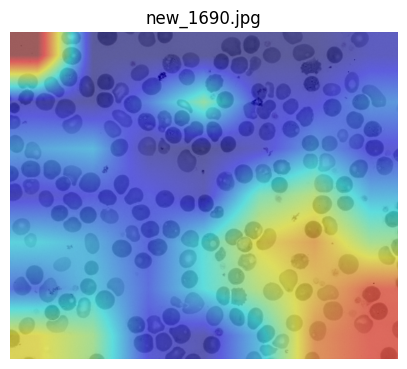

Processing: /content/drive/My Drive/DatasetV2/Normal/new_993.jpg


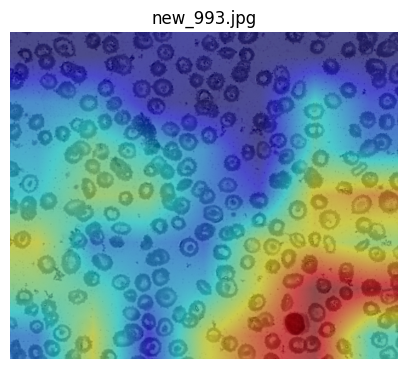

Processing: /content/drive/My Drive/DatasetV2/Normal/new_1614.jpg


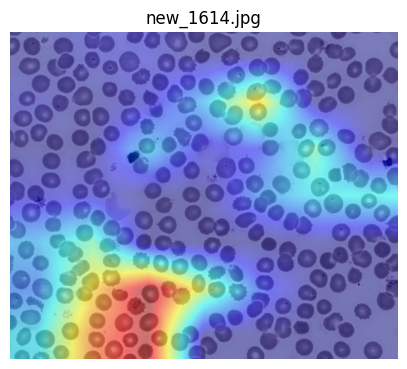

Processing: /content/drive/My Drive/DatasetV2/Normal/new_841.jpg


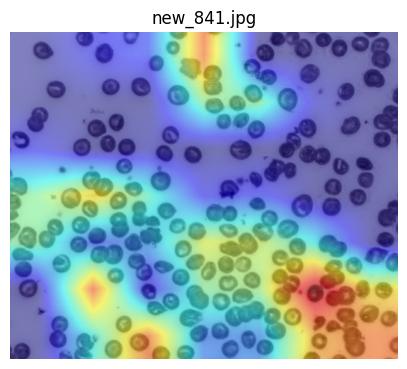

Processing: /content/drive/My Drive/DatasetV2/Normal/new_1604.jpg


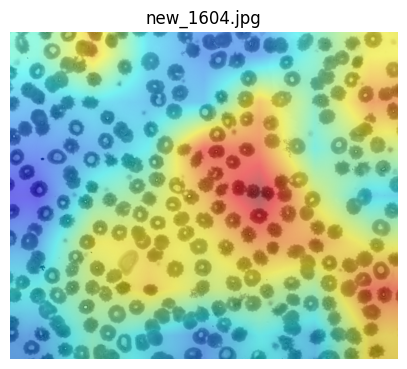

Processing: /content/drive/My Drive/DatasetV2/Sickle/new_49.jpg


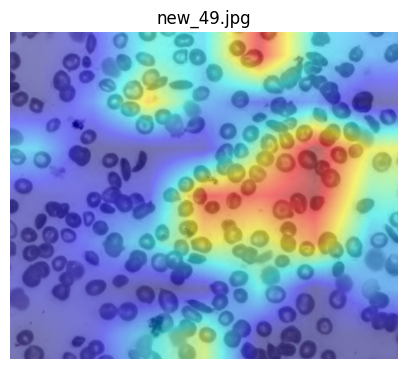

Processing: /content/drive/My Drive/DatasetV2/Sickle/new_196.jpg


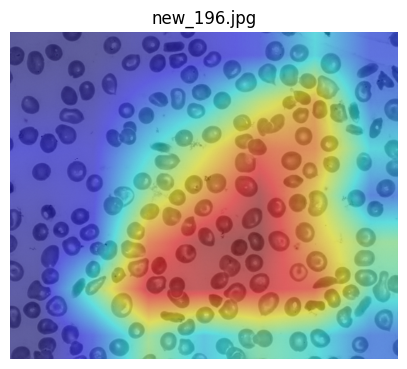

Processing: /content/drive/My Drive/DatasetV2/Sickle/new_634.jpg


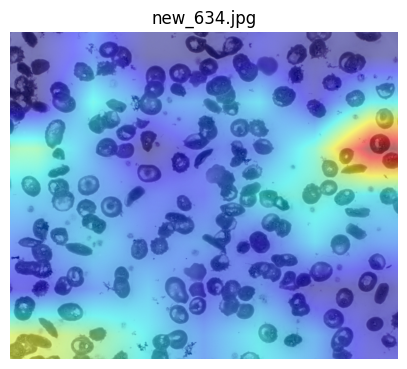

Processing: /content/drive/My Drive/DatasetV2/Sickle/new_576.jpg


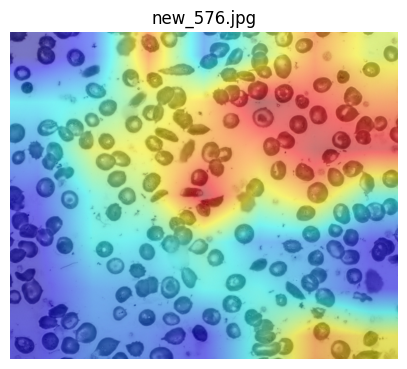

Processing: /content/drive/My Drive/DatasetV2/Sickle/new_482.jpg


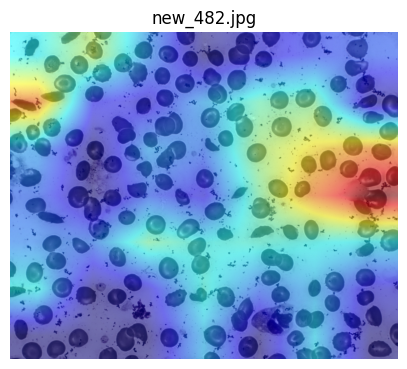

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# 0️⃣ Mount Google Drive (only in Colab)
from google.colab import drive
drive.mount('/content/drive')

# 1️⃣ Dummy Cast so mixed-precision layers don’t break load_model
class Cast(Layer):
    def call(self, x): return x

# 2️⃣ Load your binary classifier (swap in your actual path)
MODEL_PATH = '/content/drive/My Drive/resnet50_embedding_model.h5'
model = load_model(MODEL_PATH, compile=False, custom_objects={'Cast': Cast})
model.summary()

# 3️⃣ Preprocess helper
def preprocess_image(path):
    img = load_img(path, target_size=(224,224))
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr)

# 4️⃣ Grad-CAM
def generate_gradcam(model, img_tensor, layer_name):
    grad_model = Model(model.inputs,
                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)                          # ∂y/∂A
    weights = tf.reduce_mean(grads, axis=(0,1,2))                  # global avg pool
    conv_out = conv_out[0].numpy()
    weights  = weights.numpy()
    # weight the channels
    for i in range(weights.shape[-1]):
        conv_out[:,:,i] *= weights[i]
    heatmap = np.mean(conv_out, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_val = heatmap.max() if heatmap.size else 0.0
    if max_val == 0:
        return None
    heatmap /= max_val
    return heatmap.astype('float32')

# 5️⃣ Overlay helper
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    if heatmap is None or heatmap.size==0:
        print(f"⚠️ Skipping overlay for {img_path}: invalid heatmap")
        return cv2.imread(img_path)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    # ensure heatmap is proper float32 2D
    hm = heatmap
    if hm.ndim!=2:
        hm = hm.squeeze()
    hm = cv2.resize(hm, (w,h), interpolation=cv2.INTER_LINEAR)
    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, alpha, hm, 1-alpha, 0)

# 6️⃣ Gather test images
NORMAL_DIR = '/content/drive/My Drive/DatasetV2/Normal'
SICKLE_DIR = '/content/drive/My Drive/DatasetV2/Sickle'
normal_imgs = [os.path.join(NORMAL_DIR, f)
               for f in os.listdir(NORMAL_DIR)
               if f.lower().endswith(('png','jpg','jpeg'))]
sickle_imgs = [os.path.join(SICKLE_DIR, f)
               for f in os.listdir(SICKLE_DIR)
               if f.lower().endswith(('png','jpg','jpeg'))]

selected = random.sample(normal_imgs, min(5,len(normal_imgs))) \
         + random.sample(sickle_imgs, min(5,len(sickle_imgs)))

# 7️⃣ Run Grad-CAM on each
TARGET_LAYER = 'conv5_block3_out'
for img_path in selected:
    print("Processing:", img_path)
    inp = preprocess_image(img_path)
    heatmap = generate_gradcam(model, inp, TARGET_LAYER)
    overlaid = overlay_heatmap(img_path, heatmap)
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(overlaid, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "EmbeddingModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 224, 224,  │          0 │ cast_7[0][0]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast_6[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,858,688 (91.01 MB)

 Trainable params: 23,801,216 (90.79 MB)

 Non-trainable params: 57,472 (224.50 KB)

Processing: /content/drive/My Drive/DatasetV2/Work/new_65.jpg


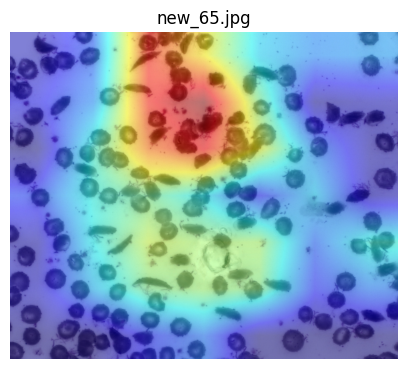

Processing: /content/drive/My Drive/DatasetV2/Work/new_535.jpg


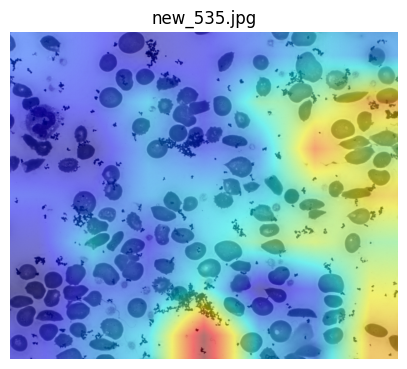

Processing: /content/drive/My Drive/DatasetV2/Work/new_66.jpg


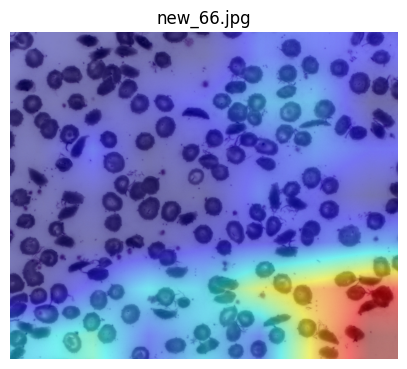

Processing: /content/drive/My Drive/DatasetV2/Work/new_67.jpg


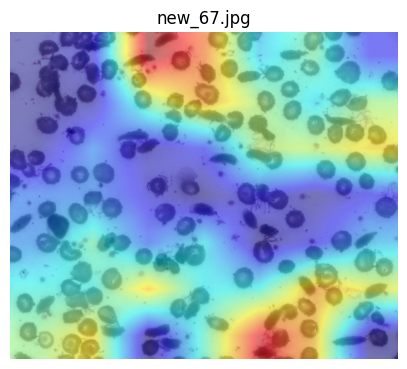

Processing: /content/drive/My Drive/DatasetV2/Work/new_663.jpg


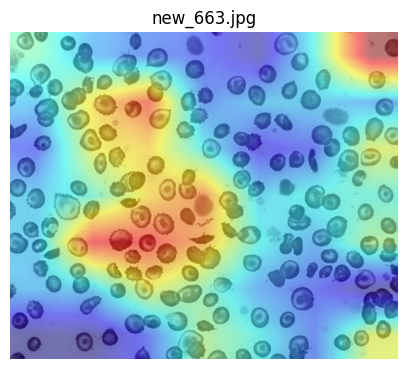

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# 0️⃣ (If you’re in Colab) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1️⃣ Dummy Cast shim so mixed-precision layers load properly
class Cast(Layer):
    def call(self, x): return x

# 2️⃣ Load your binary classifier
MODEL_PATH = '/content/drive/My Drive/resnet50_embedding_model.h5'
model = load_model(MODEL_PATH, compile=False, custom_objects={'Cast': Cast})
model.summary()

# 3️⃣ Preprocess helper
def preprocess_image(path):
    img = load_img(path, target_size=(224,224))
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr.astype('float32'))

# 4️⃣ Grad-CAM generator
def generate_gradcam(model, img_tensor, layer_name):
    grad_model = Model(model.inputs,
                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads   = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0].numpy()
    weights  = weights.numpy()
    for i, w in enumerate(weights):
        conv_out[:,:,i] *= w
    heatmap = np.mean(conv_out, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() == 0:
        return None
    heatmap /= heatmap.max()
    return heatmap.astype('float32')

# 5️⃣ Overlay helper
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    if img is None or heatmap is None:
        return img
    h, w = img.shape[:2]
    hm = cv2.resize(heatmap, (w,h), interpolation=cv2.INTER_LINEAR)
    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, alpha, hm, 1-alpha, 0)

# 6️⃣ Now point to /DatasetV2/Work (instead of Normal/Sickle)
WORK_DIR = '/content/drive/My Drive/DatasetV2/Work'
all_imgs = [
    os.path.join(WORK_DIR, f)
    for f in os.listdir(WORK_DIR)
    if f.lower().endswith(('png','jpg','jpeg'))
]

# pick e.g. 5 random examples
selected = random.sample(all_imgs, min(5, len(all_imgs)))

# 7️⃣ Run Grad-CAM
TARGET_LAYER = 'conv5_block3_out'
for img_path in selected:
    print("Processing:", img_path)
    inp     = preprocess_image(img_path)
    heatmap = generate_gradcam(model, inp, TARGET_LAYER)
    overlaid= overlay_heatmap(img_path, heatmap)
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(overlaid, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()
